## load packages to be used

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown
import geopandas as gpd
from IPython.display import Image
import stackstac # build an on-demand STAC data cube
from rasterio.enums import Resampling
import shapely # create vector objects
import dask.array as da # handle dask arrays
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.simplefilter("ignore", category=UserWarning)
print("Packages loaded successfully")

Packages loaded successfully


In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-2-l2a")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-2-l2a

The [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days.  This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) and converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

In [3]:
time_of_interest = "2024-01-01/2024-12-31"

### Define the area of interest and search Sentinel-2 Red and NIR Bands

In [4]:
import xarray as xr
import fsspec

aoi_bbox = [33.9, 0.1, 34.6, 0.8]
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [aoi_bbox[0], aoi_bbox[1]], [aoi_bbox[0], aoi_bbox[3]],  
        [aoi_bbox[2], aoi_bbox[3]], [aoi_bbox[2], aoi_bbox[1]],  
        [aoi_bbox[0], aoi_bbox[1]],  
    ]]
}

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest, 
    datetime=time_of_interest, 
    query={"eo:cloud_cover": {"lt": 10}}
)
items = search.item_collection()

print(f"Found {len(items)} Scenes of Sentinel-2 for Busia County")

Found 63 Scenes of Sentinel-2 for Busia County


### Available Assets and Metadata

In [5]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Key                ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ AOT                │       │
│ B01                │       │
│ B02                │       │
│ B03                │       │
│ B04                │       │
│ B05                │       │
│ B06                │       │
│ B07                │       │
│ B08                │       │
│ B09                │       │
│ B11                │       │
│ B12                │       │
│ B8A                │       │
│ SCL                │       │
│ WVP                │       │
│ visual             │       │
│ safe-manifest      │       │
│ granule-metadata   │       │
│ inspire-metadata   │       │
│ product-metadata   │       │
│ datastrip-metadata │       │
│ tilejson           │       │
│ rendered_preview   │       │
└────────────────────┴───────┘

In [6]:
import stackstac
import planetary_computer

In [7]:
# Sign the STAC item
signed_item = planetary_computer.sign(items[0])

In [8]:
# Stack the red (B04) and NIR (B08) bands into an xarray.DataArray
stack = stackstac.stack(signed_item, assets=["B04", "B08"], resolution=10, epsg=32636).persist()
stack

<xarray.DataArray 'stackstac-86d042778f88c5d7e58c82a3251d2ead' (time: 1,
                                                                band: 2,
                                                                y: 10982,
                                                                x: 3936)> Size: 692MB
dask.array<fetch_raster_window, shape=(1, 2, 10982, 3936), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * time                                     (time) datetime64[ns] 8B 2024-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * x                                        (x) float64 31kB 5.704e+05 ... 6...
  * y                                        (y) float64 88kB 1e+05 ... -9.78...
    s2:generation_time                       <U27 108B '2024-12-31T11:04:47.0...
    ...                                       ...
    proj:transform                           object 8B {0.0, 10.0, 499980.0, ...
    title                                    (band) <U18 144B 'Band 4 - Red -...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(570440, -9790, 609800, 100030...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 570440.00|\n| 0.00,-10.00, 100030.00|\n| 0.00...
    resolution:  10

In [9]:
# Extract the red and NIR bands
red_band = stack.sel(band="B04")  # Select the red band (B04)
nir_band = stack.sel(band="B08")  # Select the NIR band (B08)

In [10]:
# Compute NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndvi

<xarray.DataArray 'stackstac-86d042778f88c5d7e58c82a3251d2ead' (time: 1,
                                                                y: 10982,
                                                                x: 3936)> Size: 346MB
dask.array<truediv, shape=(1, 10982, 3936), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                     (time) datetime64[ns] 8B 2024-12...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * x                                        (x) float64 31kB 5.704e+05 ... 6...
  * y                                        (y) float64 88kB 1e+05 ... -9.78...
    s2:generation_time                       <U27 108B '2024-12-31T11:04:47.0...
    sat:orbit_state                          <U10 40B 'descending'
    ...                                       ...
    s2:water_percentage                      float64 8B 36.72
    proj:bbox                                object 8B {100020.0, -9780.0, 60...
    gsd                                      float64 8B 10.0
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0.0, 10.0, 499980.0, ...
    epsg                                     int64 8B 32636

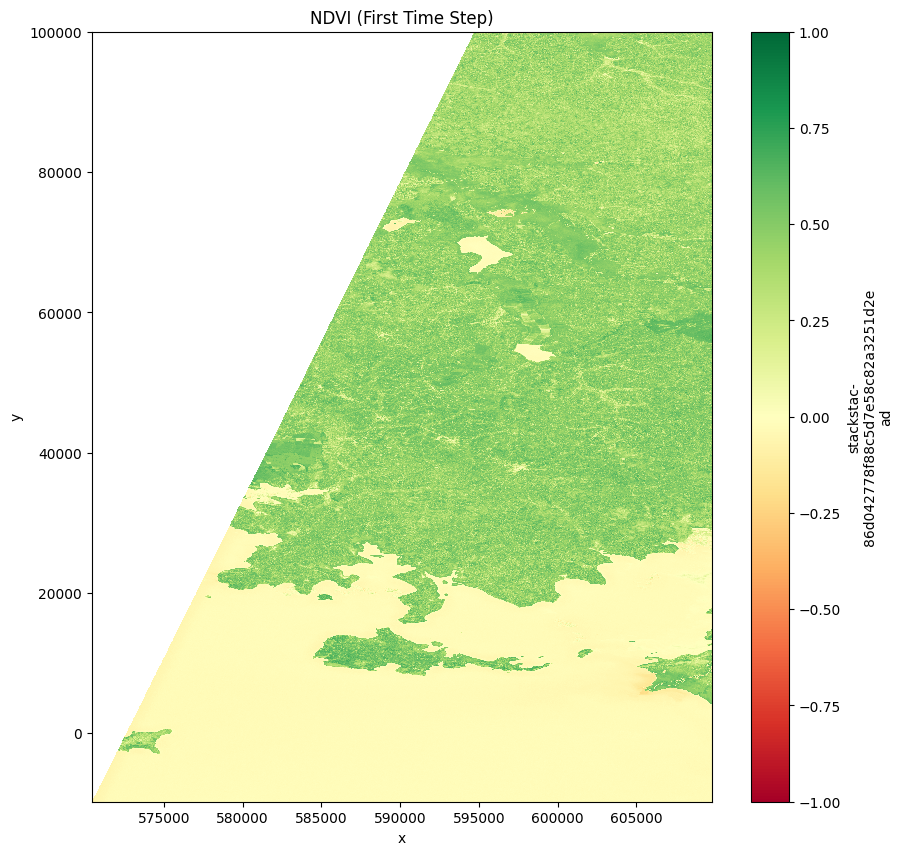

In [11]:
# Plot a single time step
import matplotlib.pyplot as plt
ndvi.isel(time=0).plot(cmap="RdYlGn", vmin=-1, vmax=1, figsize=(10, 10))
plt.title("NDVI (First Time Step)")
plt.show()

#### Utilizing GPU

In [12]:
# import rasterio
# import cupy as cp
# import matplotlib.pyplot as plt
# from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetName

In [13]:
# # Verify GPU
# nvmlInit()
# handle = nvmlDeviceGetHandleByIndex(0)  # Use GPU 0
# gpu_name = nvmlDeviceGetName(handle)
# print(f"GPU Name: {gpu_name}")

In [14]:
# # Load the red band (B04)
# with rasterio.open(items[0].assets["B04"].href) as src:
#     red_band = src.read(1)

In [15]:
# # Load the NIR band (B08)
# with rasterio.open(items[0].assets["B08"].href) as src:
#     nir_band = src.read(1)

In [16]:
# # Transfer data to GPU
# red_band_gpu = cp.asarray(red_band)
# nir_band_gpu = cp.asarray(nir_band)

In [17]:
# # Compute NDVI on GPU
# ndvi_gpu = (nir_band_gpu - red_band_gpu) / (nir_band_gpu + red_band_gpu)

In [18]:
# # Transfer result back to CPU (if needed)
# ndvi = cp.asnumpy(ndvi_gpu)

In [19]:
# # Visualize NDVI
# plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
# plt.colorbar(label="NDVI")
# plt.title("NDVI January")
# plt.show()

### Other Datasets
#### Sentinel 2

In [20]:
earth_search_api_url = "https://earth-search.aws.element84.com/v1"

time_of_interest = "2024-01-01/2024-12-31"

# Catalog
catalog = pystac_client.Client.open(earth_search_api_url)

# Query Sentinel-2 NDVI
sentinel2_items = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest, 
    query={"eo:cloud_cover": {"lt": 10}}
).item_collection()

# Explore sentinel-2 items as dataframes.
sentinel_2_items_df = gpd.GeoDataFrame.from_features(sentinel2_items.to_dict(), crs="epsg:32636")
sentinel_2_items_df

,geometry,created,platform,constellation,instruments,eo:cloud_cover,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,grid:code,...,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,proj:code,s2:dark_features_percentage
0,"POLYGON ((33.852 0.905, 33.634 -0.088, 33.987 ...",2024-12-31T12:32:26.775Z,sentinel-2a,sentinel-2,[msi],2.682315,36,N,WF,MGRS-36NWF,...,1.034080,2024-12-31T08:10:04.026000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/W...,roda-sentinel2/workflow-sentinel2-to-stac/6fbd...,True,{'sentinel2-to-stac': '0.1.1'},2024-12-31T12:32:26.775Z,EPSG:32636,NaN
1,"POLYGON ((33 0.905, 33 -0.088, 33.812 -0.087, ...",2024-12-29T11:25:26.324Z,sentinel-2b,sentinel-2,[msi],2.268725,36,N,WF,MGRS-36NWF,...,1.033919,2024-12-29T08:19:59.354000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/W...,roda-sentinel2/workflow-sentinel2-to-stac/884a...,True,{'sentinel2-to-stac': '0.1.1'},2024-12-29T11:25:26.324Z,EPSG:32636,NaN
2,"POLYGON ((33.899 0.905, 33.899 0.311, 34.029 0...",2024-12-29T10:59:21.670Z,sentinel-2b,sentinel-2,[msi],0.045219,36,N,XF,MGRS-36NXF,...,1.033919,2024-12-29T08:19:52.003000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/X...,roda-sentinel2/workflow-sentinel2-to-stac/8ec3...,True,{'sentinel2-to-stac': '0.1.1'},2024-12-29T10:59:21.670Z,EPSG:32636,NaN
3,"POLYGON ((33.851 0.905, 33.633 -0.088, 33.987 ...",2024-12-11T12:42:38.926Z,sentinel-2a,sentinel-2,[msi],0.761265,36,N,WF,MGRS-36NWF,...,1.030660,2024-12-11T08:10:04.363000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/W...,roda-sentinel2/workflow-sentinel2-to-stac/ad35...,True,{'sentinel2-to-stac': '0.1.1'},2024-12-11T12:42:38.926Z,EPSG:32636,NaN
4,"POLYGON ((33.899 0.905, 33.899 -0.088, 34.885 ...",2024-12-11T12:56:31.354Z,sentinel-2a,sentinel-2,[msi],3.419567,36,N,XF,MGRS-36NXF,...,1.030660,2024-12-11T08:10:00.786000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/X...,roda-sentinel2/workflow-sentinel2-to-stac/f6f2...,True,{'sentinel2-to-stac': '0.1.1'},2024-12-11T12:56:31.354Z,EPSG:32636,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"POLYGON ((33.855 0.905, 33.637 -0.088, 33.987 ...",2024-02-20T12:11:16.227Z,sentinel-2b,sentinel-2,[msi],4.567888,36,N,WF,MGRS-36NWF,...,1.024975,2024-02-20T08:10:04.210000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/W...,roda-sentinel2/workflow-sentinel2-to-stac/945a...,True,{'sentinel2-to-stac': '0.1.1'},2024-02-20T12:11:16.227Z,EPSG:32636,0.027411
60,"POLYGON ((33.899 0.905, 33.899 0.315, 34.029 0...",2024-02-13T12:31:56.088Z,sentinel-2b,sentinel-2,[msi],8.149595,36,N,XF,MGRS-36NXF,...,1.027631,2024-02-13T08:19:51.524000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/X...,roda-sentinel2/workflow-sentinel2-to-stac/3bc7...,True,{'sentinel2-to-stac': '0.1.1'},2024-02-13T12:31:56.088Z,EPSG:32636,0.000083
61,"POLYGON ((33.899 0.905, 33.899 0.288, 34.035 0...",2024-01-24T12:34:20.508Z,sentinel-2b,sentinel-2,[msi],6.281681,36,N,XF,MGRS-36NXF,...,1.032908,2024-01-24T08:19:49.710000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/X...,roda-sentinel2/workflow-sentinel2-to-stac/47ac...,True,{'sentinel2-to-stac': '0.1.1'},2024-01-24T12:34:20.508Z,EPSG:32636,0.004334
62,"POLYGON ((33 0.905, 33 -0.088, 33.835 -0.087, ...",2024-01-19T13:17:15.958Z,sentinel-2a,sentinel-2,[msi],3.411549,36,N,WF,MGRS-36NWF,...,1.033630,2024-01-19T08:19:49.094000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/36/N/W...,roda-sentinel2/workflow-sentinel2-to-stac/3f6a...,True,{'sentinel2-to-stac': '0.1.1'},2024-01-19T13:17:15.958Z,EPSG:32636,0.020637


In [21]:
sentinel_2_items_df.shape

(64, 42)

In [22]:
sentinel_2_items_df.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:cloud_shadow_percentage', 's2:vegetation_percentage',
       's2:not_vegetated_percentage', 's2:water_percentage',
       's2:unclassified_percentage', 's2:medium_proba_clouds_percentage',
       's2:high_proba_clouds_percentage', 's2:thin_cirrus_percentage',
       's2:snow_ice_percentage', 's2:product_type', 's2:processing_baseline',
       's2:product_uri', 's2:generation_time', 's2:datatake_id',
       's2:datatake_type', 's2:datastrip_id', 's2:granule_id',
       's2:reflectance_conversion_factor', 'datetime', 's2:sequence',
       'earthsearch:s3_path', 'earthsearch:payload_id',
       'earthsearch:boa_offset_applied', 'processing:so

In [23]:
# Filtering sentinel-2 data further with a cloud cover lower than 5% and with a no-data pixel percentage below 10%.
ids = sentinel_2_items_df.loc[
  (sentinel_2_items_df['eo:cloud_cover'] <= 2) &
  (sentinel_2_items_df['s2:nodata_pixel_percentage'] <= 5)
]
sentinel_2_item = sentinel2_items[ids.index[0]]
sentinel_2_item.datetime

datetime.datetime(2024, 8, 28, 8, 10, 1, 789000, tzinfo=tzutc())

In [24]:
thumbnail = sentinel_2_item.assets["thumbnail"].href
Image(url = thumbnail)

In [25]:
# Sentinel two stac
s2_stack = stackstac.stack(
    sentinel2_items, 
    assets=["nir", "red"], 
    resolution=10, 
    epsg=32636, 
    resampling=Resampling.bilinear)

# Compute NDVI
nir = s2_stack.sel(band="nir")
red = s2_stack.sel(band="red")

ndvi = (nir - red) / (nir + red).where((nir + red) != 0, np.nan)  # Avoid divide by zero
ndvi

<xarray.DataArray 'stackstac-bc5b0eae84d37dc9b2c87d9e5d053ff6' (time: 64,
                                                                y: 10986,
                                                                x: 20985)> Size: 118GB
dask.array<truediv, shape=(64, 10986, 20985), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 512B 2024-...
    id                                       (time) <U24 6kB 'S2A_36NXF_20240...
  * x                                        (x) float64 168kB 5e+05 ... 7.09...
  * y                                        (y) float64 88kB 1.001e+05 ... -...
    earthsearch:boa_offset_applied           bool 1B True
    s2:generation_time                       (time) <U27 7kB '2024-01-19T11:2...
    ...                                       ...
    s2:vegetation_percentage                 (time) float64 512B 91.22 ... 58.29
    s2:water_percentage                      (time) object 512B 0.000118 ... ...
    gsd                                      int64 8B 10
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32636

### Retrieve Dates for December 2024

In [26]:
# Ensure time is in datetime format (only needed if not already)
ndvi["time"] = ndvi["time"].astype("datetime64[ns]")

# Filter dates for December 2024
december_dates = ndvi.time[(ndvi.time.dt.month == 1) & (ndvi.time.dt.year == 2024)]

# Display the available dates
print(december_dates.values)

['2024-01-19T08:19:42.227000000' '2024-01-19T08:19:49.094000000'
 '2024-01-24T08:19:49.710000000']


In [27]:
# Convert to pandas DateTime for easier formatting
import pandas as pd

formatted_dates = pd.to_datetime(december_dates.values).strftime('%Y-%m-%d')
print(formatted_dates)

Index(['2024-01-19', '2024-01-19', '2024-01-24'], dtype='object')


### Extract all dates

In [28]:
import pandas as pd

# Convert time coordinates from stackstac (assuming time is in s2_stack index)
all_dates = pd.to_datetime(s2_stack.time.values)

# Filter only dates from 2024
dates_2024 = all_dates[all_dates.year == 2024]

# Format as YYYY-MM-DD
formatted_dates_2024 = dates_2024.strftime('%Y-%m-%d')

# Display unique dates
print(formatted_dates_2024.unique())

Index(['2024-01-19', '2024-01-24', '2024-02-13', '2024-02-20', '2024-03-04',
       '2024-03-11', '2024-03-14', '2024-03-16', '2024-03-19', '2024-04-23',
       '2024-04-30', '2024-05-08', '2024-05-13', '2024-05-28', '2024-05-30',
       '2024-06-02', '2024-06-04', '2024-06-07', '2024-06-19', '2024-07-02',
       '2024-07-04', '2024-07-09', '2024-07-14', '2024-08-08', '2024-08-11',
       '2024-08-13', '2024-08-16', '2024-08-23', '2024-08-28', '2024-09-05',
       '2024-09-12', '2024-09-17', '2024-09-27', '2024-10-15', '2024-10-17',
       '2024-10-22', '2024-10-25', '2024-11-14', '2024-12-09', '2024-12-11',
       '2024-12-29', '2024-12-31'],
      dtype='object')


### Group NDVI by Month and Compute Mean for each Month

In [29]:
# Group NDVI by month and compute mean for each month
ndvi_monthly = ndvi.groupby("time.month").mean(dim="time")
ndvi_monthly

<xarray.DataArray 'stackstac-bc5b0eae84d37dc9b2c87d9e5d053ff6' (month: 12,
                                                                y: 10986,
                                                                x: 20985)> Size: 22GB
dask.array<stack, shape=(12, 10986, 20985), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * x                                        (x) float64 168kB 5e+05 ... 7.09...
  * y                                        (y) float64 88kB 1.001e+05 ... -...
    earthsearch:boa_offset_applied           bool 1B True
    mgrs:utm_zone                            int64 8B 36
    constellation                            <U10 40B 'sentinel-2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    s2:saturated_defective_pixel_percentage  int64 8B 0
    gsd                                      int64 8B 10
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32636
  * month                                    (month) int64 96B 1 2 3 ... 11 12

#### Extract Month Names & Corresponding NDVI

In [30]:
print(ndvi_monthly.month.values)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


### Plot NDVI

In [31]:
print(ndvi_monthly.x.min().values, ndvi_monthly.x.max().values)
print(ndvi_monthly.y.min().values, ndvi_monthly.y.max().values)

499980.0 709820.0
-9780.0 100070.0


In [32]:
from pyproj import Transformer

# Define the transformer from WGS84 (lat/lon) to UTM Zone 36N
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32636", always_xy=True)

# Convert Busia Village bounding box (longitude, latitude) → (x, y)
busia_utm_minx, busia_utm_miny = transformer.transform(34.05, 0.25)
busia_utm_maxx, busia_utm_maxy = transformer.transform(34.25, 0.45)

print(busia_utm_minx, busia_utm_miny)  # Check converted values
print(busia_utm_maxx, busia_utm_maxy)

616844.1905598236 27637.185224176163
639100.5504255975 49750.449589390075


In [33]:
ndvi_village = ndvi_monthly.sel(
    x=slice(busia_utm_minx, busia_utm_maxx),
    y=slice(busia_utm_maxy, busia_utm_miny)  # Reverse y order
)

print(ndvi_village.shape)  # Should now show (12, height, width)

(12, 2212, 2226)


In [34]:
type(ndvi_monthly)

xarray.core.dataarray.DataArray

In [35]:
ndvi_village

<xarray.DataArray 'stackstac-bc5b0eae84d37dc9b2c87d9e5d053ff6' (month: 12,
                                                                y: 2212, x: 2226)> Size: 473MB
dask.array<getitem, shape=(12, 2212, 2226), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * x                                        (x) float64 18kB 6.168e+05 ... 6...
  * y                                        (y) float64 18kB 4.975e+04 ... 2...
    earthsearch:boa_offset_applied           bool 1B True
    mgrs:utm_zone                            int64 8B 36
    constellation                            <U10 40B 'sentinel-2'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    s2:saturated_defective_pixel_percentage  int64 8B 0
    gsd                                      int64 8B 10
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32636
  * month                                    (month) int64 96B 1 2 3 ... 11 12

### Visualize the NDVI of the Village

In [ ]:
# Plot a single time step
import matplotlib.pyplot as plt
ndvi_monthly.isel(month=1).plot(cmap="RdYlGn", vmin=-1, vmax=1, figsize=(10, 10))
plt.title("Village Level NDVI January")
plt.show()

### Plotting

In [ ]:
# Plot a single time step
import matplotlib.pyplot as plt
ndvi_village.isel(month=1).plot(cmap="RdYlGn", vmin=-1, vmax=1, figsize=(10, 10))
plt.title("Village Level NDVI January")
plt.show()